In [9]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [54]:
os.chdir('..') # change working directory to root

In [60]:
from agents.td3 import TD3
from agents.d3qn import D3QN
from agents.implicit_q_learning import ImplicitQLearning
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace
from mdp.mimic_iii.state_spaces.sparse_autoencoder import SparseAutoEncoder as MimicIIISparseAutoEncoderStateSpace
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from utilities import mimic_iii_funcs

In [27]:
batch_size = 512

# load and preprocess mimic data
discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(0)
continuous_mimic_df = discrete_mimic_df.copy()
discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'iql_discrete')
continuous_mimic_df, continuous_min_max_scaler, action_min_max_scaler = mimic_iii_funcs.preprocess_mimic_data(continuous_mimic_df, 'ddpg_cont')
action_mins, action_maxs = mimic_iii_funcs.get_cont_action_space_bounds(continuous_mimic_df)
# discrete split
(
    (discrete_train_states, discrete_train_actions, discrete_train_next_states, discrete_train_rewards, discrete_train_dones),
    (discrete_val_states, discrete_val_actions, discrete_val_next_states, discrete_val_rewards, discrete_val_dones),
    (discrete_test_states, discrete_test_actions, discrete_test_next_states, discrete_test_rewards, discrete_test_dones)
) = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'iql_discrete')
# continuous split
(
    (continuous_train_states, continuous_train_actions, continuous_train_next_states, continuous_train_rewards, continuous_train_dones),
    (continuous_val_states, continuous_val_actions, continuous_val_next_states, continuous_val_rewards, continuous_val_dones),
    (continuous_test_states, continuous_test_actions, continuous_test_next_states, continuous_test_rewards, continuous_test_dones)
) = mimic_iii_funcs.train_val_test_split_mimic_data(continuous_mimic_df, 'ddpg_cont')
# create discrete dataloaders
discrete_train_dataset = mimic_iii_funcs.ImplicitQLearningDataset(discrete_train_states, discrete_train_actions, discrete_train_next_states, discrete_train_rewards, discrete_train_dones)
discrete_train_dataloader = torch.utils.data.DataLoader(discrete_train_dataset, batch_size=batch_size, shuffle=False)
discrete_val_dataset = mimic_iii_funcs.ImplicitQLearningDataset(discrete_val_states, discrete_val_actions, discrete_val_next_states, discrete_val_rewards, discrete_val_dones)
discrete_val_dataloader = torch.utils.data.DataLoader(discrete_val_dataset, batch_size=batch_size, shuffle=False)
discrete_test_dataset = mimic_iii_funcs.ImplicitQLearningDataset(discrete_test_states, discrete_test_actions, discrete_test_next_states, discrete_test_rewards, discrete_test_dones)
discrete_test_dataloader = torch.utils.data.DataLoader(discrete_test_dataset, batch_size=batch_size, shuffle=False)
# create continuous dataloaders
continuous_train_dataset = mimic_iii_funcs.ImplicitQLearningDataset(continuous_train_states, continuous_train_actions, continuous_train_next_states, continuous_train_rewards, continuous_train_dones)
continuous_train_dataloader = torch.utils.data.DataLoader(continuous_train_dataset, batch_size=batch_size, shuffle=False)
continuous_val_dataset = mimic_iii_funcs.ImplicitQLearningDataset(continuous_val_states, continuous_val_actions, continuous_val_next_states, continuous_val_rewards, continuous_val_dones)
continuous_val_dataloader = torch.utils.data.DataLoader(continuous_val_dataset, batch_size=batch_size, shuffle=False)
continuous_test_dataset = mimic_iii_funcs.ImplicitQLearningDataset(continuous_test_states, continuous_test_actions, continuous_test_next_states, continuous_test_rewards, continuous_test_dones)
continuous_test_dataloader = torch.utils.data.DataLoader(continuous_test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
mlflow_path = os.path.join('file:///', '<your_base_path>', 'mimic-iii', 'mlruns')
mlflow.set_tracking_uri(mlflow_path)
behavior_policy_runid = '61ed4ffa0b9f4fb593ef328ceed2f72c'
behavior_policy = KMeansSarsa(n_clusters=8, n_actions=len(DiscreteActionSpace), num_episodes=1, reward_scale=15.0)
behavior_policy.load_model(behavior_policy_runid, 'split_0')

state_space_runid = 'fda6c8118cd54d36a258db25e37969a2'
state_space_ae = mlflow.pytorch.load_model(f'runs:/{state_space_runid}/final_sparse_ae_split_0')
state_space_ae.eval()

td3_runid = '99dc1e37e45d43fc9599214bf53ce1f1'
td3_agent = TD3(0.99, 1e-4, 1e-4, 5e-3, 32, 0, 200, 2, action_mins, action_maxs, 32, 15.0, 5.0, 0.2, 0.9, 1e-2, 2, 100)
td3_agent.load_model(f'runs:/{td3_runid}/final_ddpg_model_split_0')
td3_agent.eval()

d3qn_runid = '577b4dbe786848eeb9b64bc675ffd686'
d3qn_agent = D3QN(0.99, 1e-4, 5e-3, 32, 1, 200, 1, 25, 128, 15.0, 5.0, 0.2, 0.9, 1e-2)
d3qn_agent.load_model(f'runs:/{d3qn_runid}/final_d3qn_model_split_0')
d3qn_agent.eval()

iql_runid = 'f2e58c3e06b44fd582f761f6249b96b9'
iql_agent = ImplicitQLearning(200, 1, 25, 128, 128, 128, 1e-4, 1e-4, 1e-4, 0.99)
iql_agent.load_model(f'runs:/{iql_runid}/final_iql_model_split_0')
iql_agent.eval()

/Users/larry/anaconda3/envs/ope_310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024/09/16 14:00:12 WARNING mlflow.pytorch: Stored model version '2.2.2' does not match installed PyTorch version '2.0.1'
2024/09/16 14:00:13 WARNING mlflow.pytorch: Stored model version '2.2.2' does not match installed PyTorch version '2.0.1'
2024/09/16 14:00:14 WARNING mlflow.pytorch: Stored model version '2.2.2' does not match installed PyTorch version '2.0.1'
2024/09/16 14:00:15 WARNING mlflow.pytorch: Stored model version '2.2.2' does not match installed PyTorch version '2.0.1'
2024/09/16 14:00:16 WARNING mlflow.pytorch: Stored model version '2.2.2' does not match installe

In [29]:
def iql_agent_eval(iql_agent_: ImplicitQLearning, dataloader: torch.utils.data.DataLoader, cont_state_space_ae: MimicIIISparseAutoEncoderStateSpace) -> torch.LongTensor:
    all_eval_actions = None
    with torch.no_grad():
        for i, (states, actions, next_states, rewards, dones) in enumerate(dataloader):
            states = cont_state_space_ae.encode(states).detach()
            cur_actions, _ = iql_agent_.get_best_action(states)
            if all_eval_actions is None:
                all_eval_actions = cur_actions.action
            else:
                all_eval_actions = torch.cat((all_eval_actions, cur_actions.action), dim=0)
    return all_eval_actions

def d3qn_agent_eval(d3qn_agent_: D3QN, dataloader: torch.utils.data.DataLoader, cont_state_space_ae: MimicIIISparseAutoEncoderStateSpace) -> torch.LongTensor:
    all_eval_actions = None
    with torch.no_grad():
        for i, (states, actions, next_states, rewards, dones) in enumerate(dataloader):
            states = cont_state_space_ae.encode(states).detach()
            cur_actions, _ = d3qn_agent_.get_best_action(states)
            if all_eval_actions is None:
                all_eval_actions = cur_actions.action
            else:
                all_eval_actions = torch.cat((all_eval_actions, cur_actions.action), dim=0)
    return all_eval_actions

def ddpg_agent_eval(ddpg_agent_: TD3, dataloader: torch.utils.data.DataLoader, cont_state_space_ae: MimicIIISparseAutoEncoderStateSpace, return_discrete_actions: bool, action_scaler: MinMaxScaler) -> torch.LongTensor | torch.FloatTensor:
    all_eval_actions = None
    with torch.no_grad():
        for i, (states, actions, next_states, rewards, dones) in enumerate(dataloader):
            states = cont_state_space_ae.encode(states).detach()
            cur_actions, _ = ddpg_agent_.get_best_action(states)
            cur_actions = torch.from_numpy(action_scaler.inverse_transform(cur_actions.action.cpu().numpy())).float()
            if return_discrete_actions:
                # convert actions to discrete
                cur_discrete_actions = torch.empty(cur_actions.shape[0], dtype=torch.long, device=cur_actions.device)
                for i in range(cur_actions.shape[0]):
                    cur_val = cur_actions[i].cpu()
                    cur_discrete_actions[i] = DiscreteActionSpace.Continuous_To_Discrete(cur_val[0].item(), cur_val[1].item()).value
                cur_actions = cur_discrete_actions
            if all_eval_actions is None:
                all_eval_actions = cur_actions
            else:
                all_eval_actions = torch.cat((all_eval_actions, cur_actions), dim=0)
    return all_eval_actions

In [30]:
iql_train_actions = iql_agent_eval(iql_agent, discrete_train_dataloader, state_space_ae).numpy()
iql_val_actions = iql_agent_eval(iql_agent, discrete_val_dataloader, state_space_ae).numpy()
iql_test_actions = iql_agent_eval(iql_agent, discrete_test_dataloader, state_space_ae).numpy()
d3qn_train_actions = d3qn_agent_eval(d3qn_agent, discrete_train_dataloader, state_space_ae).numpy()
d3qn_val_actions = d3qn_agent_eval(d3qn_agent, discrete_val_dataloader, state_space_ae).numpy()
d3qn_test_actions = d3qn_agent_eval(d3qn_agent, discrete_test_dataloader, state_space_ae).numpy()
ddpg_train_actions = ddpg_agent_eval(td3_agent, continuous_train_dataloader, state_space_ae, return_discrete_actions=True, action_scaler=action_min_max_scaler).numpy()
ddpg_val_actions = ddpg_agent_eval(td3_agent, continuous_val_dataloader, state_space_ae, return_discrete_actions=True, action_scaler=action_min_max_scaler).numpy()
ddpg_test_actions = ddpg_agent_eval(td3_agent, continuous_test_dataloader, state_space_ae, return_discrete_actions=True, action_scaler=action_min_max_scaler).numpy()

In [31]:
np_vec_fn_to_vaso = np.vectorize(lambda x: DiscreteActionSpace.Extract_VP_From_Action(int(x)))
np_vec_fn_to_fluid = np.vectorize(lambda x: DiscreteActionSpace.Extract_IV_Fluids_From_Action(int(x)))
iql_train_vaso = np_vec_fn_to_vaso(iql_train_actions)
iql_train_fluid = np_vec_fn_to_fluid(iql_train_actions)
iql_val_vaso = np_vec_fn_to_vaso(iql_val_actions)
iql_val_fluid = np_vec_fn_to_fluid(iql_val_actions)
iql_test_vaso = np_vec_fn_to_vaso(iql_test_actions)
iql_test_fluid = np_vec_fn_to_fluid(iql_test_actions)
d3qn_train_vaso = np_vec_fn_to_vaso(d3qn_train_actions)
d3qn_train_fluid = np_vec_fn_to_fluid(d3qn_train_actions)
d3qn_val_vaso = np_vec_fn_to_vaso(d3qn_val_actions)
d3qn_val_fluid = np_vec_fn_to_fluid(d3qn_val_actions)
d3qn_test_vaso = np_vec_fn_to_vaso(d3qn_test_actions)
d3qn_test_fluid = np_vec_fn_to_fluid(d3qn_test_actions)
ddpg_train_vaso = np_vec_fn_to_vaso(ddpg_train_actions)
ddpg_train_fluid = np_vec_fn_to_fluid(ddpg_train_actions)
ddpg_val_vaso = np_vec_fn_to_vaso(ddpg_val_actions)
ddpg_val_fluid = np_vec_fn_to_fluid(ddpg_val_actions)
ddpg_test_vaso = np_vec_fn_to_vaso(ddpg_test_actions)
ddpg_test_fluid = np_vec_fn_to_fluid(ddpg_test_actions)

In [32]:
np.unique(iql_val_actions)

array([ 0,  5, 10, 15, 20, 24])

In [33]:
# now extract behavior policy actions
discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(0)
# NOTE: not scaling rewards here - it's not necessary
# reward_fn.update_rewards(mimic_df)  # scale rewards
discrete_mimic_df, _, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'kmeans_sarsa')
train_df, val_df, test_df = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'kmeans_sarsa')
for df in [train_df, val_df, test_df]:
    df['discrete_state'] = behavior_policy.discretize_states(np.vstack(df['state'].to_numpy()).astype(np.float32))
    df['discrete_next_state'] = behavior_policy.discretize_states(np.vstack(df['next_state'].to_numpy()).astype(np.float32))
    # add individual action columns
    df['iv_fluid_actions'] = df['a:action'].apply(lambda a: DiscreteActionSpace.Extract_IV_Fluids_From_Action(a))
    df['vasopressor_actions'] = df['a:action'].apply(lambda a: DiscreteActionSpace.Extract_VP_From_Action(a))
    # get physician actions
    df['learned_actions'] = behavior_policy.get_actions(df['discrete_state'].to_numpy())
    df['iv_fluid_learned'] = df['learned_actions'].apply(lambda a: DiscreteActionSpace.Extract_IV_Fluids_From_Action(a))
    df['vasopressor_learned'] = df['learned_actions'].apply(lambda a: DiscreteActionSpace.Extract_VP_From_Action(a))

In [34]:
behavior_policy_train_vaso = train_df['vasopressor_learned'].to_numpy()
behavior_policy_train_fluid = train_df['iv_fluid_learned'].to_numpy()
behavior_policy_val_vaso = val_df['vasopressor_learned'].to_numpy()
behavior_policy_val_fluid = val_df['iv_fluid_learned'].to_numpy()
behavior_policy_test_vaso = test_df['vasopressor_learned'].to_numpy()
behavior_policy_test_fluid = test_df['iv_fluid_learned'].to_numpy()
actual_train_vaso = train_df['vasopressor_actions'].to_numpy()
actual_train_fluid = train_df['iv_fluid_actions'].to_numpy()
actual_val_vaso = val_df['vasopressor_actions'].to_numpy()
actual_val_fluid = val_df['iv_fluid_actions'].to_numpy()
actual_test_vaso = test_df['vasopressor_actions'].to_numpy()
actual_test_fluid = test_df['iv_fluid_actions'].to_numpy()

In [35]:
def plot_policies(actual_vaso: np.ndarray, actual_fluid: np.ndarray, behavior_vaso: np.ndarray, behavior_fluid: np.ndarray,
                  iql_vaso: np.ndarray, iql_fluid: np.ndarray, d3qn_vaso: np.ndarray, d3qn_fluid: np.ndarray, ddpg_vaso: np.ndarray, 
                  ddpg_fluid: np.ndarray, dataset_name: str):
    hist_actual, x_edges_actual, y_edges_actual = np.histogram2d(actual_fluid, actual_vaso, bins=5, range=[[0, 5], [0, 5]])
    hist_behavior, x_edges_behavior, y_edges_behavior = np.histogram2d(behavior_fluid, behavior_vaso, bins=5, range=[[0, 5], [0, 5]])
    hist_iql, x_edges_iql, y_edges_iql = np.histogram2d(iql_fluid, iql_vaso, bins=5, range=[[0, 5], [0, 5]])
    hist_d3qn, x_edges_d3qn, y_edges_d3qn = np.histogram2d(d3qn_fluid, d3qn_vaso, bins=5, range=[[0, 5], [0, 5]])
    hist_ddpg, x_edges_ddpg, y_edges_ddpg = np.histogram2d(ddpg_fluid, ddpg_vaso, bins=5, range=[[0, 5], [0, 5]])
    f, (ax_actual, ax_behavior, ax_iql, ax_d3qn, ax_ddpg) = plt.subplots(1, 5, figsize=(24, 8))
    for ax, hist, x_edges, y_edges, title in zip([ax_actual, ax_behavior, ax_iql, ax_d3qn, ax_ddpg], 
                                                 [hist_actual, hist_behavior, hist_iql, hist_d3qn, hist_ddpg], 
                                                 [x_edges_actual, x_edges_behavior, x_edges_iql, x_edges_d3qn, x_edges_ddpg], 
                                                 [y_edges_actual, y_edges_behavior, y_edges_iql, y_edges_d3qn, y_edges_ddpg], 
                                                 ['Actual policy', 'Behavior policy', 'IQL policy', 'D3QN policy', 'DDPG policy']):
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_yticks(np.arange(0, 5, 1))
        ax.set_xticklabels(np.arange(0, 5, 1))
        ax.set_yticklabels(np.arange(0, 5, 1))
        ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 5, 1), minor=True)
        ax.imshow(np.flipud(hist), cmap="Blues", extent=[x_edges[0], x_edges[-1],  y_edges[0], y_edges[-1]])
        ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
        im = ax.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
        f.colorbar(im, ax=ax, label="Action counts")
        ax.set_ylabel('IV fluid dose')
        ax.set_xlabel('Vasopressor dose')
        ax.set_title(title)
    f.tight_layout()
    f.suptitle(f'{dataset_name} Dataset Action Distributions', fontsize=16)
    plt.show()

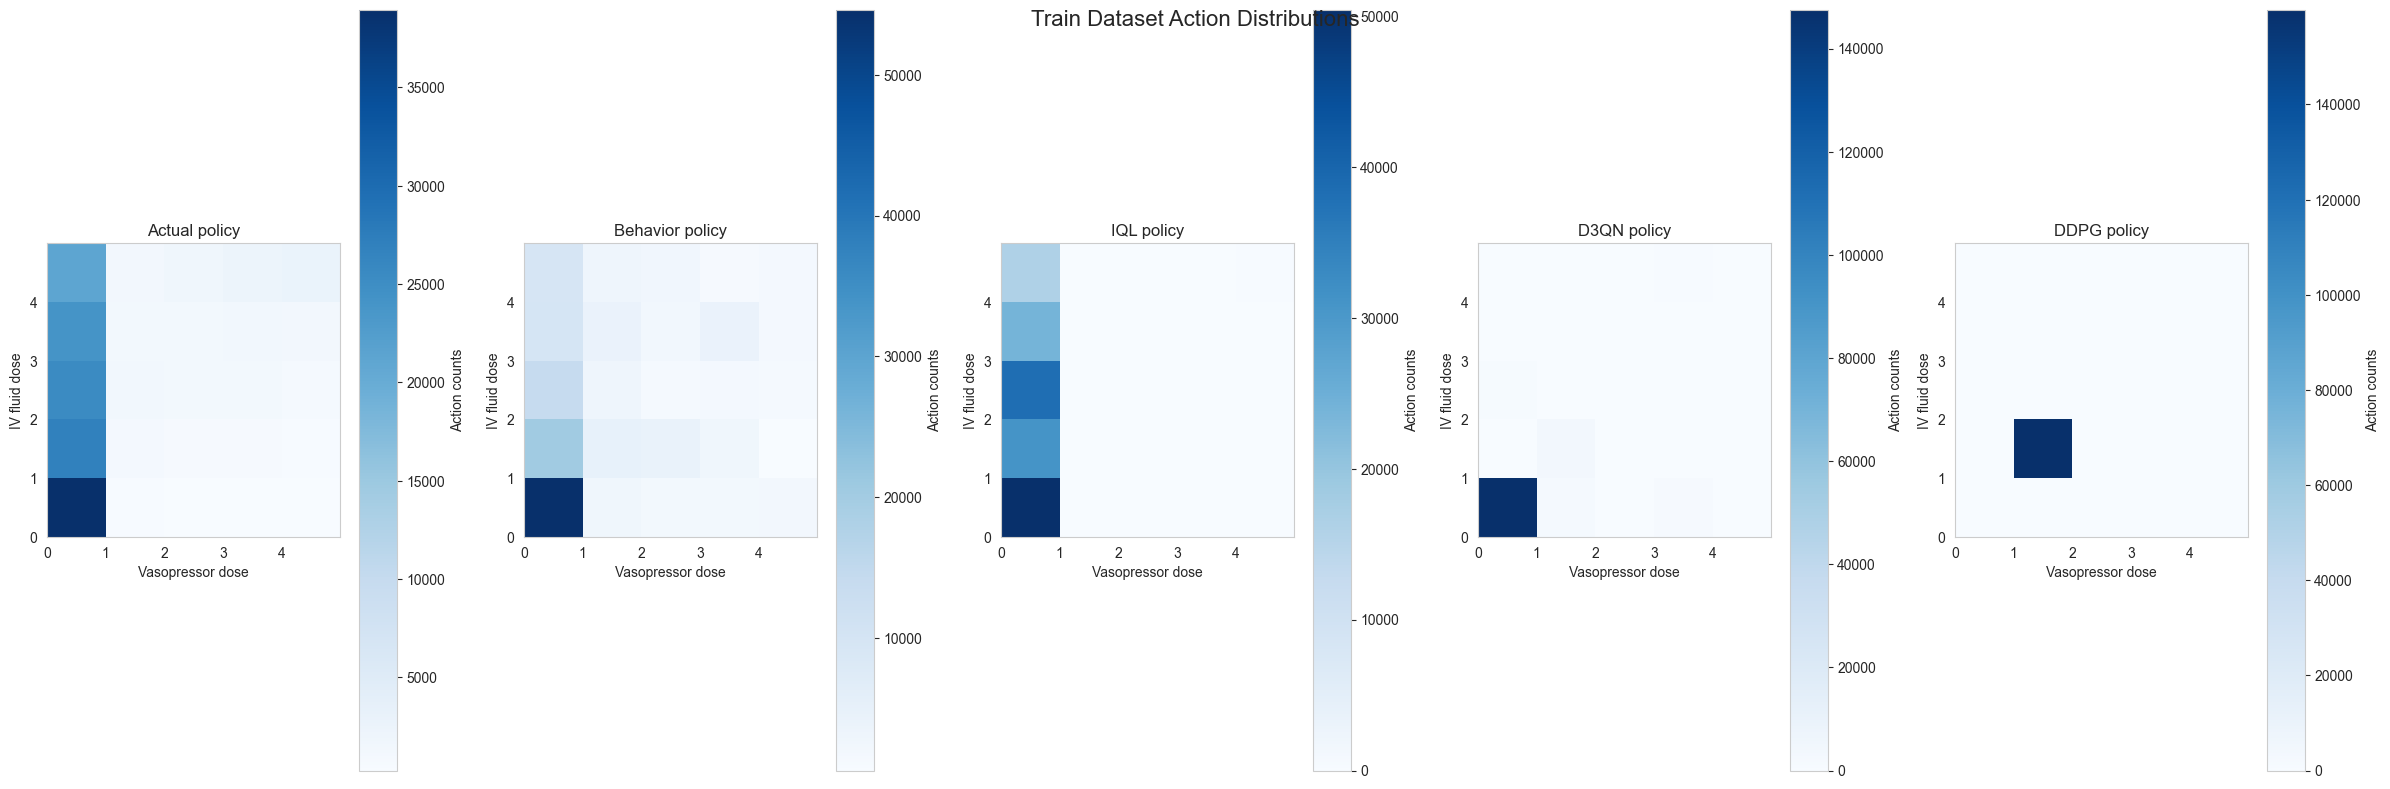

In [36]:
plot_policies(actual_train_vaso, actual_train_fluid, behavior_policy_train_vaso, behavior_policy_train_fluid, iql_train_vaso, iql_train_fluid, d3qn_train_vaso, d3qn_train_fluid, ddpg_train_vaso, ddpg_train_fluid, 'Train')

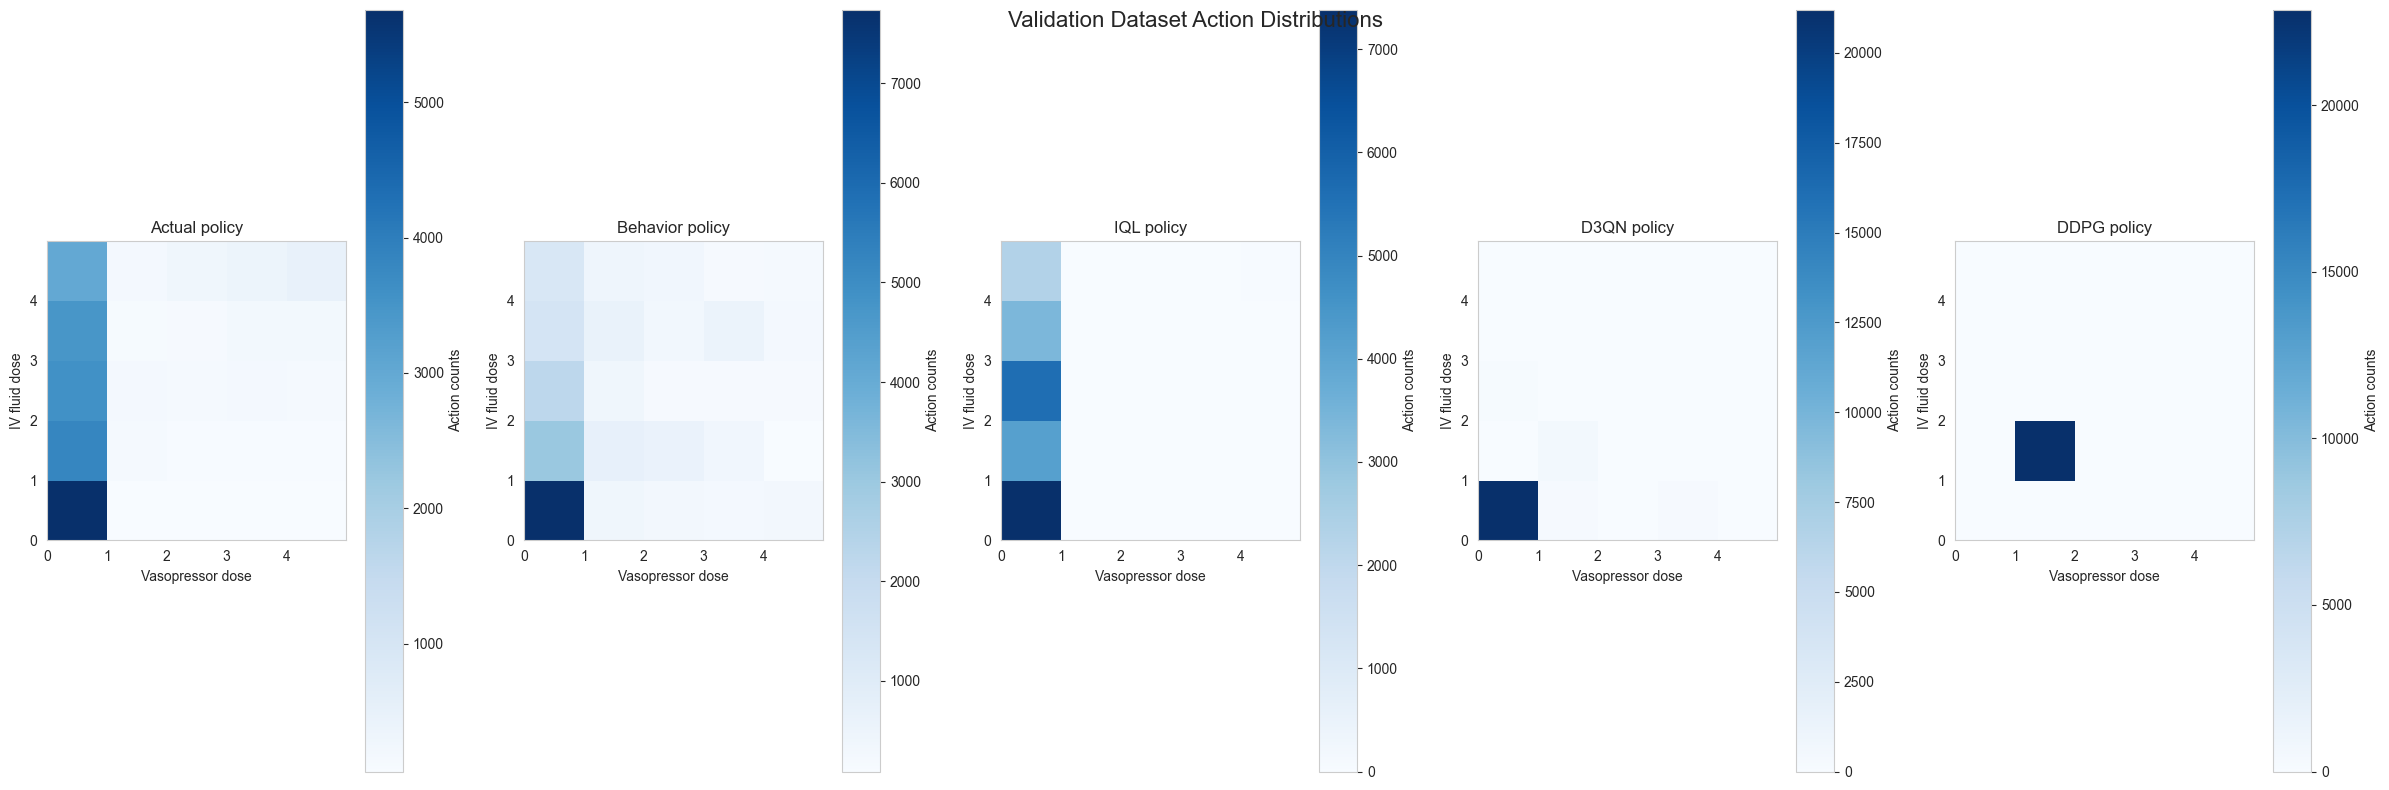

In [37]:
plot_policies(actual_val_vaso, actual_val_fluid, behavior_policy_val_vaso, behavior_policy_val_fluid, iql_val_vaso, iql_val_fluid, d3qn_val_vaso, d3qn_val_fluid, ddpg_val_vaso, ddpg_val_fluid, 'Validation')

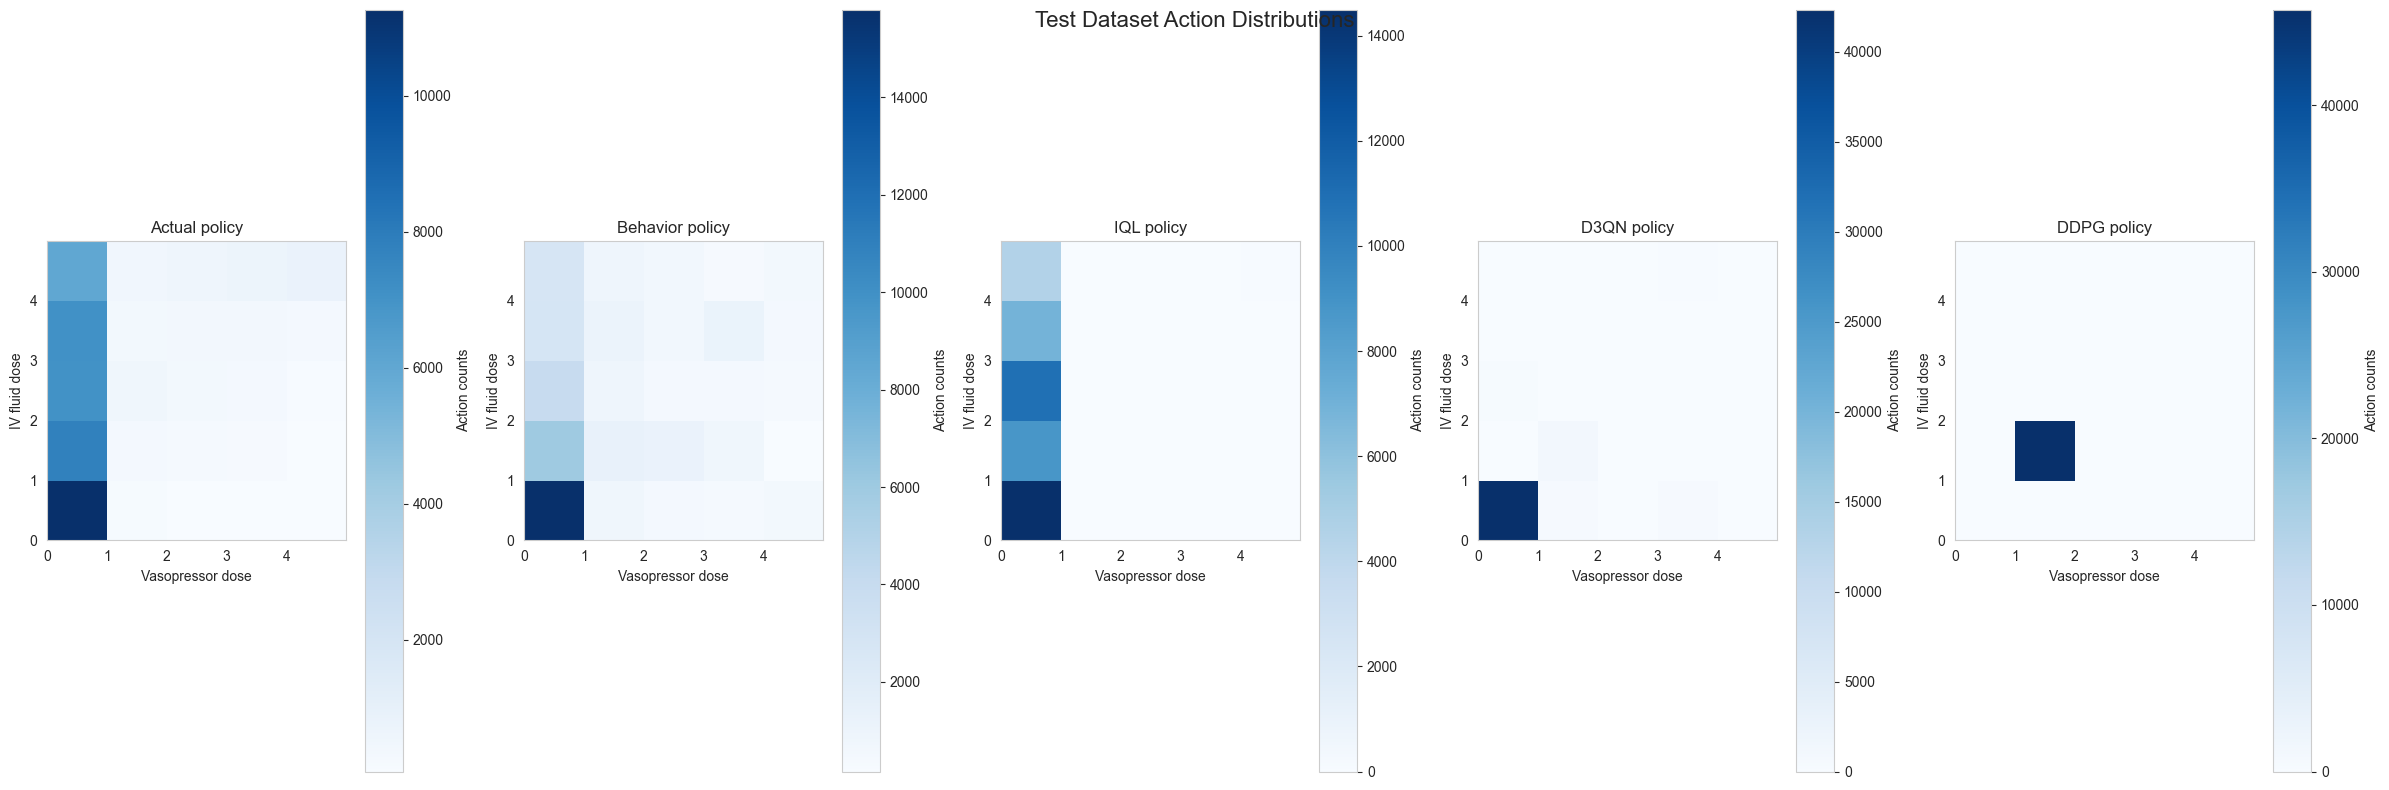

In [38]:
plot_policies(actual_test_vaso, actual_test_fluid, behavior_policy_test_vaso, behavior_policy_test_fluid, iql_test_vaso, iql_test_fluid, d3qn_test_vaso, d3qn_test_fluid, ddpg_test_vaso, ddpg_test_fluid, 'Test')

In [39]:
ddpg_train_actions = ddpg_agent_eval(td3_agent, continuous_train_dataloader, state_space_ae, return_discrete_actions=False, action_scaler=action_min_max_scaler).numpy()
ddpg_val_actions = ddpg_agent_eval(td3_agent, continuous_val_dataloader, state_space_ae, return_discrete_actions=False, action_scaler=action_min_max_scaler).numpy()
ddpg_test_actions = ddpg_agent_eval(td3_agent, continuous_test_dataloader, state_space_ae, return_discrete_actions=False, action_scaler=action_min_max_scaler).numpy()

In [40]:
def plot_cont_actions(actual_actions: np.ndarray, ddpg_actions: np.ndarray, action_scaler: MinMaxScaler, dataset_name: str):
    fig, (ax_iv, ax_vp) = plt.subplots(2, 1, figsize=(16, 24))
    cont_actions = action_scaler.inverse_transform(actual_actions)
    sns.histplot([cont_actions[:, 0], ddpg_actions[:, 0]], kde=True, bins=50, ax=ax_iv, stat='density')
    sns.histplot((cont_actions[:, 1], ddpg_actions[:, 1]), kde=True, bins=50, ax=ax_vp, stat='density')
    ax_iv.set_xlabel('IV fluid dose (ml/4hrs)')
    ax_iv.set_xticks(np.arange(0, 10001, 1000))
    ax_iv.set_xticklabels(np.arange(0, 10001, 1000))
    # ax.set_ylabel('IV fluid dose')
    # ax.set_xlabel('Vasopressor dose')
    fig.suptitle(f'{dataset_name} Dataset DDPG Continuous Action Distributions')
    #fig.tight_layout()
    for ax in (ax_iv, ax_vp):
        legend = ax.get_legend()
        handles = legend.legend_handles
        ax.legend(handles, ['Behavior', 'DDPG'])
    plt.show()

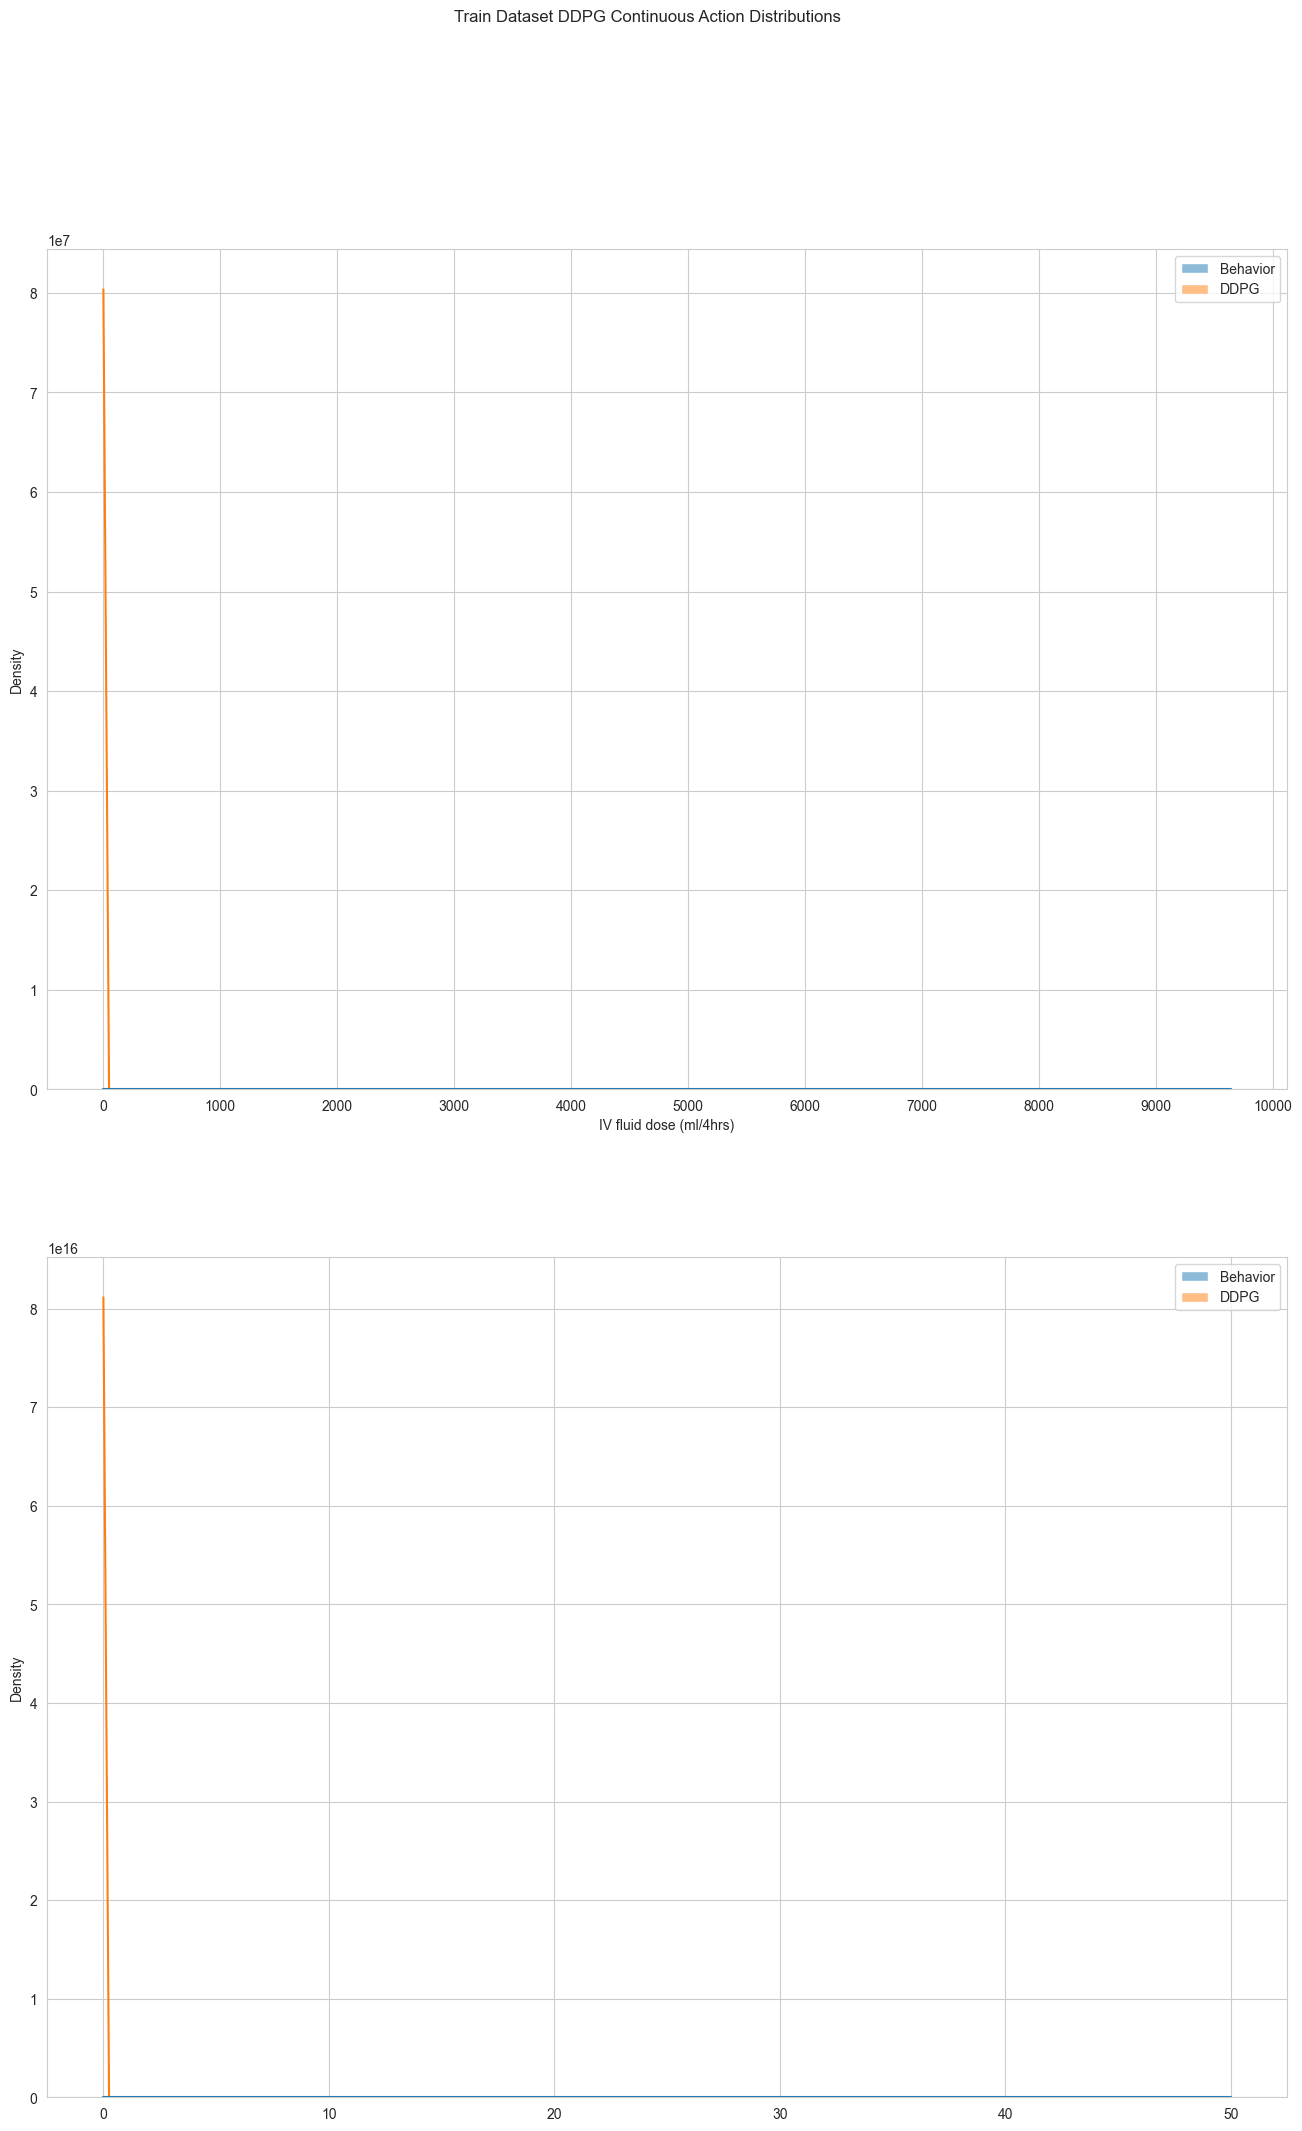

In [41]:
plot_cont_actions(continuous_train_actions.numpy(), ddpg_train_actions, action_min_max_scaler, 'Train')

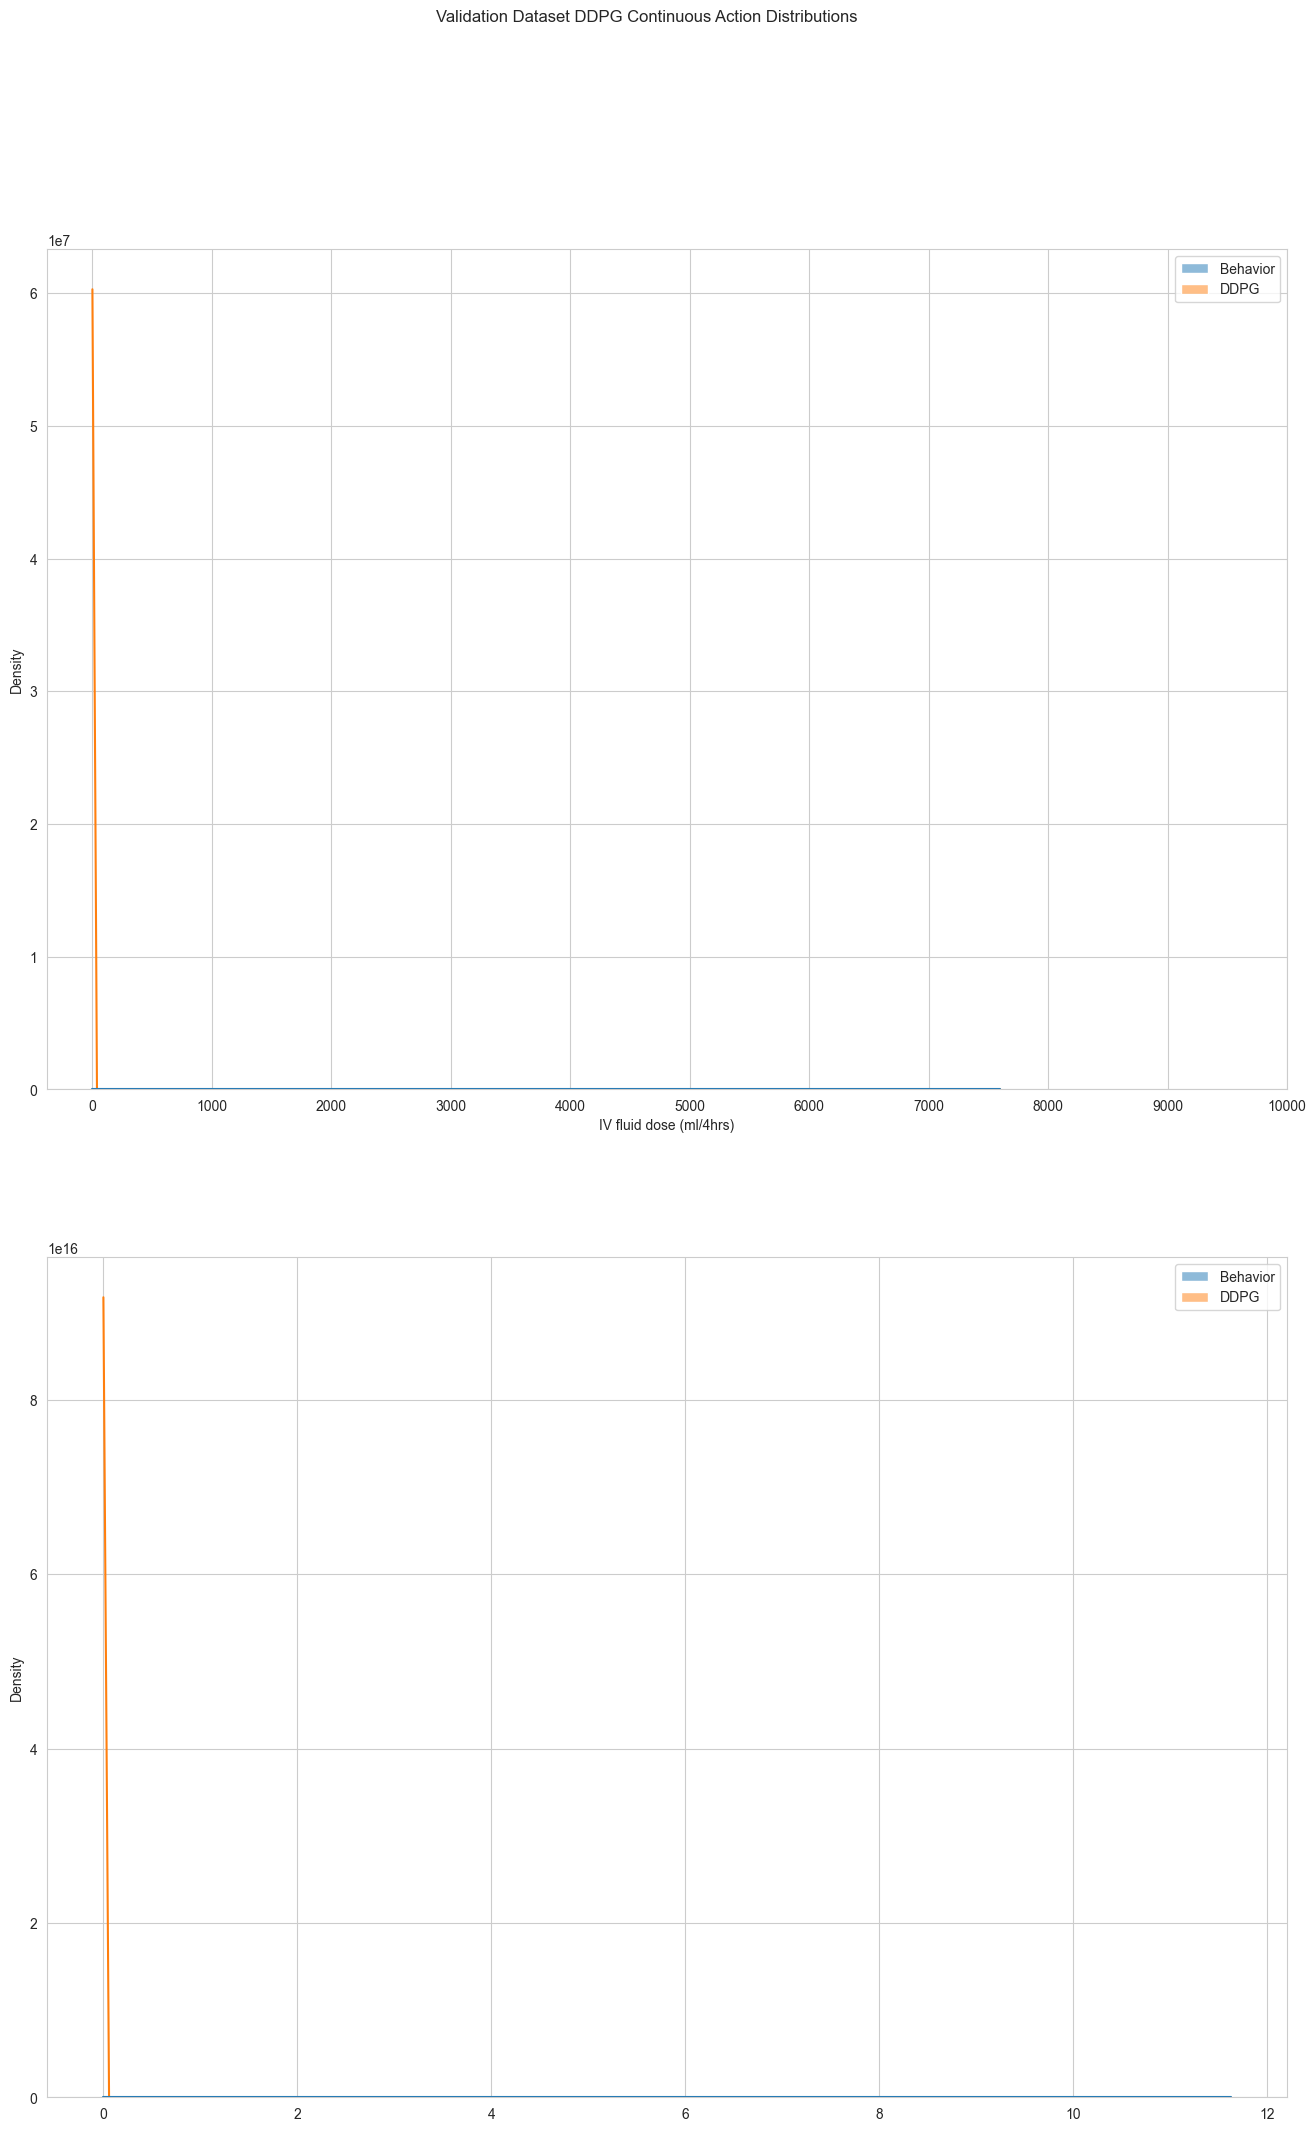

In [42]:
plot_cont_actions(continuous_val_actions.numpy(), ddpg_val_actions, action_min_max_scaler, 'Validation')

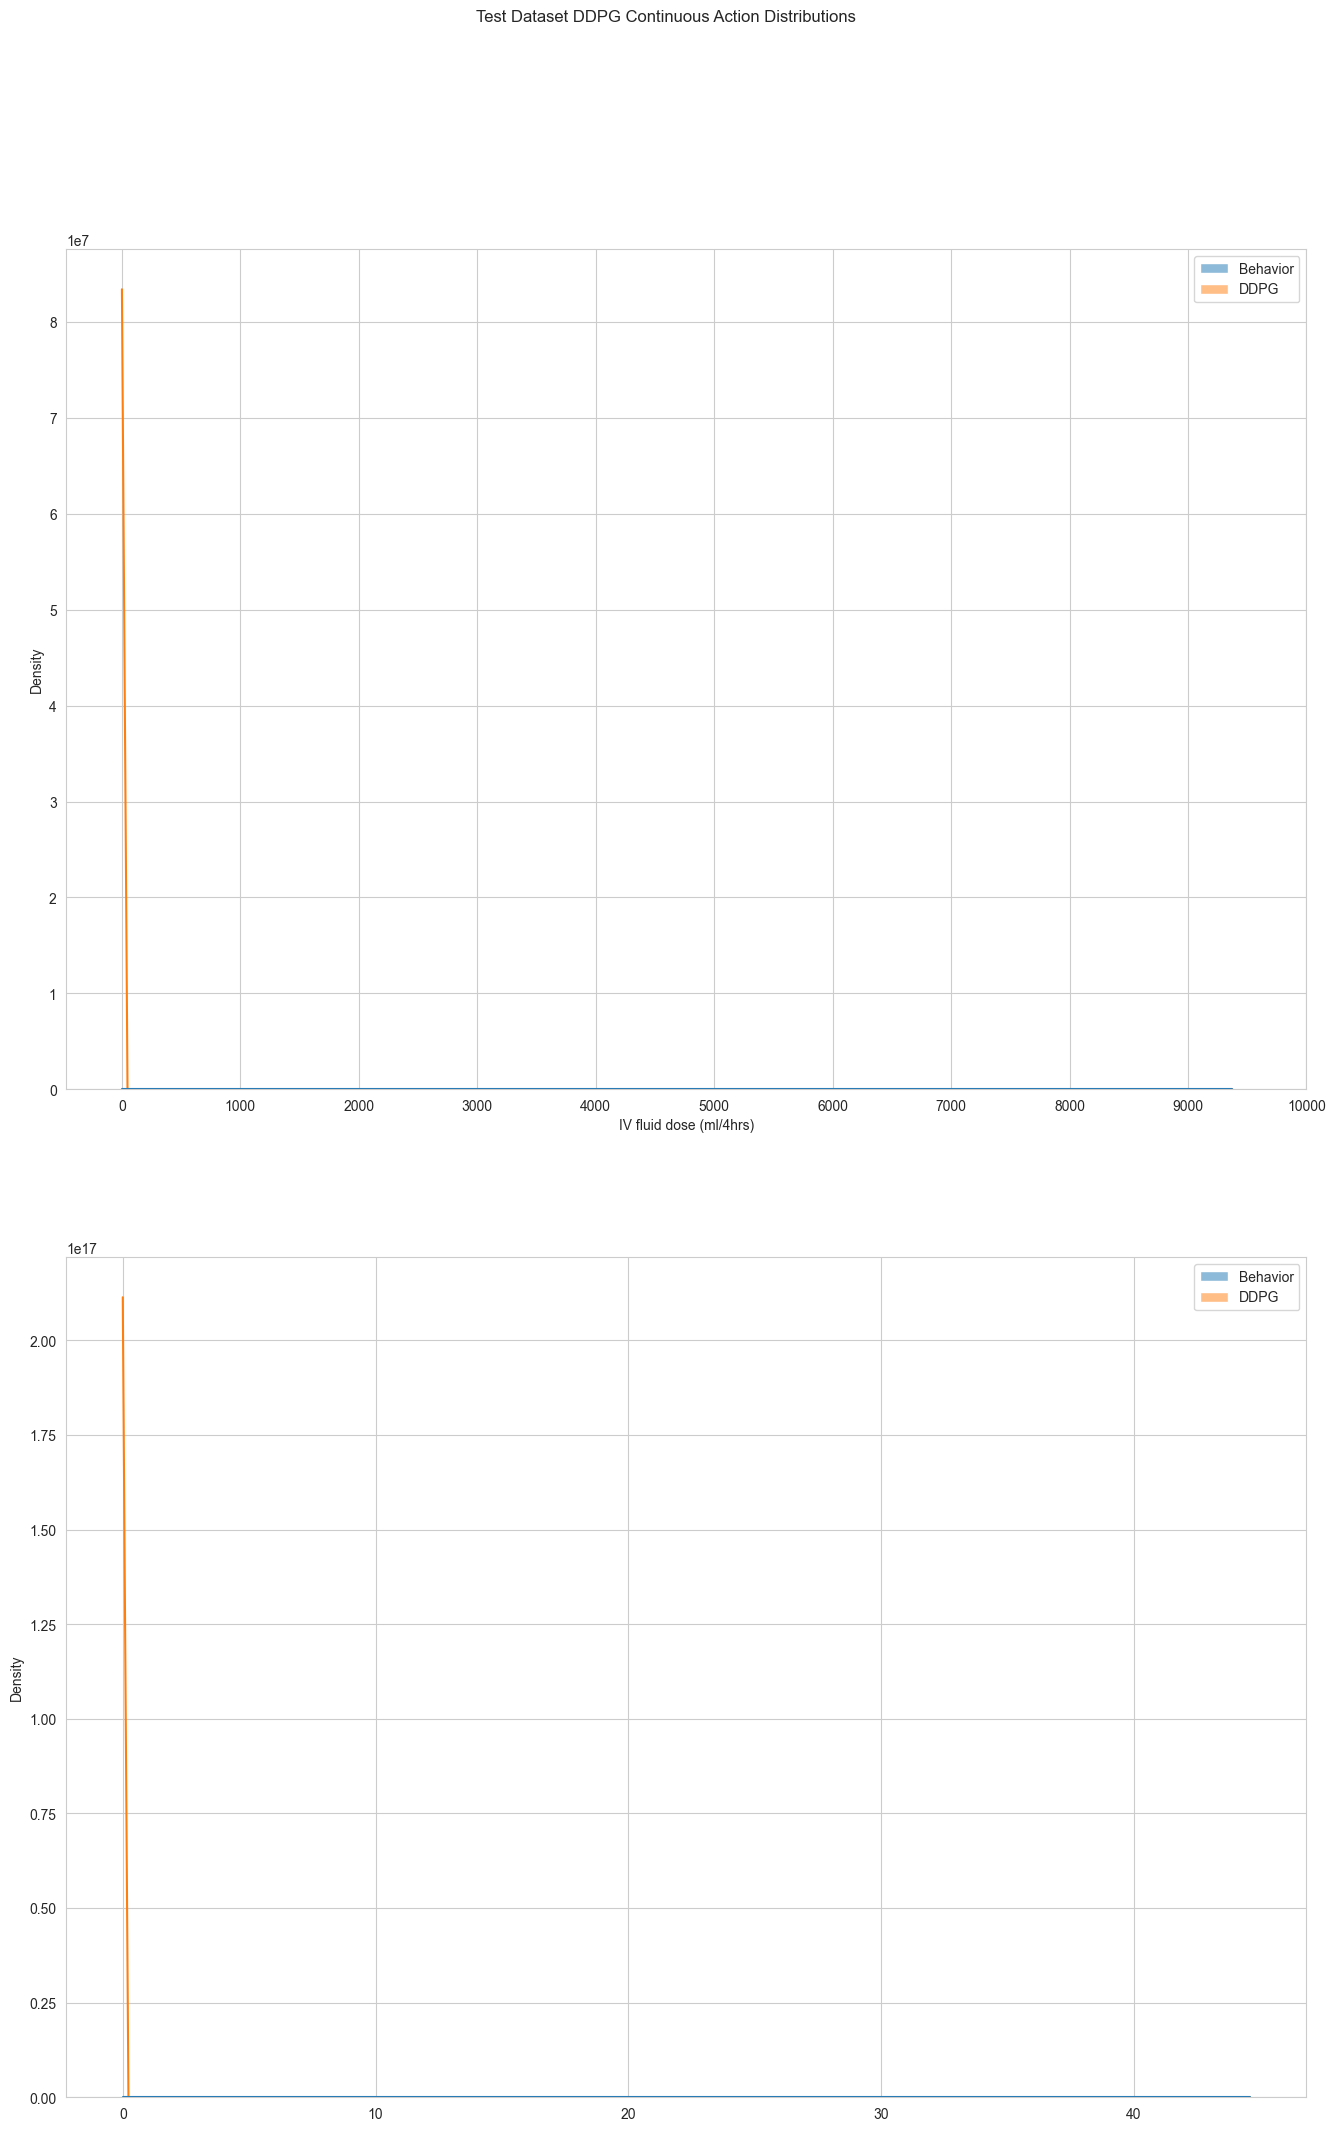

In [43]:
plot_cont_actions(continuous_test_actions.numpy(), ddpg_test_actions, action_min_max_scaler, 'Test')

In [44]:
ddpg_train_actions[:, 1].max()

8.814522e-15

In [45]:
(ddpg_train_actions[:, 1] < 1e-6).sum()

159947

In [46]:
ddpg_train_actions.shape

(159947, 2)